# Оптимизация производственных расходов

# Цель и описание проекта

Нашей основной целью является оптимизация производственных расходов для металлургического комбината . Они решили сократить потребление электроэнергии на этапе обработки стали, то есть, *научив модель определять оптимальную температуру*, мы сможем понять, как избегать лишнего нагрева, а следовательно меньше сжигать ненужной электроэнергии. 

Таким образом, **конечным результатом** нашей работы должна стать **модель регрессии**. Критерием успешности будет являтся то, что **Средняя абсолютная ошибка (MAE или Mean Absolute Error)**, будет **меньше 6.8**, то есть, грубо говоря, если модель в своих ответах будет ошибаться меньше чем на 6.8 градусов Цельсия - мы достигнем успеха.

Дополнительным плюсом будет, если мы выделим какие-то признаки, особенно сильно влияющие на результат, изменив которые, процесс станет ещё эффективнее и экономичнее.

# Содержание


- [1. Исследовательский анализ данных](#load)
- [2. Подготовка данных](#prepare)
    - [2.1. Аномальные значения](#anomalies)
    - [2.2. Группировка и сборка датафрейма](#group)
- [3. Обучение моделей](#ml)
    - [3.1. Случайный лес](#rf)
    - [3.2. Lasso Regressor](#lasso)
    - [3.3. CatBoostRegressor](#cb)
- [4. Общий вывод](#conclusion)
- [5. Отчёт о работе](#report)

<a id=load> </a>
## 1. Исследовательский анализ данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import shap
import catboost as cb

from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV

In [2]:
try:
    data_arc_new = pd.read_csv('/datasets/data_arc_new.csv')
except:
    data_arc_new = pd.read_csv('C://Users/User/Downloads//data_arc_new.csv')
    
try:
    data_bulk_new = pd.read_csv('/datasets/data_bulk_new.csv')
except:
    data_bulk_new = pd.read_csv('C://Users/User/Downloads//data_bulk_new.csv')

try:
    data_bulk_time_new = pd.read_csv('/datasets/data_bulk_time_new.csv')
except:
    data_bulk_time_new = pd.read_csv('C://Users/User/Downloads//data_bulk_time_new.csv')
    
try:
    data_gas_new = pd.read_csv('/datasets/data_gas_new.csv')
except:
    data_gas_new = pd.read_csv('C://Users/User/Downloads//data_gas_new.csv')
    
try:
    data_temp_new = pd.read_csv('/datasets/data_temp_new.csv')
except:
    data_temp_new = pd.read_csv('C://Users/User/Downloads//data_temp_new.csv')

try:
    data_wire_new = pd.read_csv('/datasets/data_wire_new.csv')
except:
    data_wire_new = pd.read_csv('C://Users/User/Downloads//data_wire_new.csv')
    
try:
    data_wire_time_new = pd.read_csv('/datasets/data_wire_time_new.csv')
except:
    data_wire_time_new = pd.read_csv('C://Users/User/Downloads//data_wire_time_new.csv')
    
datanames = {'данные об электродах':data_arc_new,
             'данные о подаче сыпучих материалов (объём)':data_bulk_new,
             'данные о продувке сплава газом':data_gas_new, 
             'результаты измерения температуры':data_temp_new, 
             'данные о проволочных материалах (объём)':data_wire_new 
             }

In [3]:
def analys(df):
    """Проводит первичный анализ данных:
    последовательно показывает
    размер, первые 10 строк, методы info, describe, количество дубликатов,
    пропущенные значения и строит корреляционную матрицу
    """
    print()
    print('Размер датафрейма:', df.shape[0], 'строк и ', df.shape[1], 'столбцов.')
    print('---------------------------------------------------------------\n')
    display(df.head(10))
    print('---------------------------------------------------------------\n')
    display(df.drop('key', axis=1).info())                                     #здесь и далее избавляется от ключа 'key'
    print('---------------------------------------------------------------\n') #чтобы он не перегружал таблицу
    display(df.drop('key', axis=1).describe())
    print('---------------------------------------------------------------\n')
    print('Дубликатов в датафрейме:', df.drop('key', axis=1).duplicated().sum())
    print('---------------------------------------------------------------\n')
    display('Больше всего пропущенных значений в столбцах:', df.drop('key', axis=1).isna().sum().sort_values(ascending=False).head(10))
    print('---------------------------------------------------------------\n')
    plt.figure(figsize = (16,5))
    sns.heatmap(df.drop('key', axis=1).corr(), cmap="YlGnBu", annot=True, linewidths=1)
    plt.show()
    print();

данные об электродах

Размер датафрейма: 14876 строк и  5 столбцов.
---------------------------------------------------------------



,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,0.261665,0.205527
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.710297,0.484962
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.786322,0.542517
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.101678,0.820856


---------------------------------------------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Начало нагрева дугой  14876 non-null  object 
 1   Конец нагрева дугой   14876 non-null  object 
 2   Активная мощность     14876 non-null  float64
 3   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), object(2)
memory usage: 465.0+ KB


None

---------------------------------------------------------------



,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000
mean,0.662752,0.438986
std,0.258885,5.873485
min,0.223120,-715.479924
25%,0.467115,0.337175
50%,0.599587,0.441639
75%,0.830070,0.608201
max,1.463773,1.270284


---------------------------------------------------------------

Дубликатов в датафрейме: 0
---------------------------------------------------------------



'Больше всего пропущенных значений в столбцах:'

Начало нагрева дугой    0
Конец нагрева дугой     0
Активная мощность       0
Реактивная мощность     0
dtype: int64

---------------------------------------------------------------



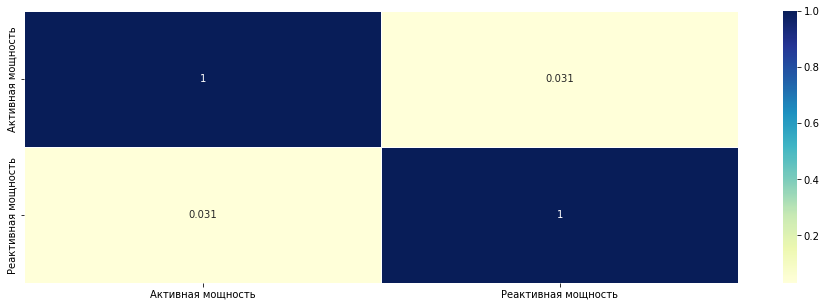


данные о подаче сыпучих материалов (объём)

Размер датафрейма: 3129 строк и  16 столбцов.
---------------------------------------------------------------



,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
5,6,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,201.0,154.0
6,7,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,152.0,154.0
7,8,NaN,NaN,NaN,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410.0,NaN,252.0,153.0
8,9,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.0,NaN,99.0,203.0
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,102.0,204.0


---------------------------------------------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Bulk 1   252 non-null    float64
 1   Bulk 2   22 non-null     float64
 2   Bulk 3   1298 non-null   float64
 3   Bulk 4   1014 non-null   float64
 4   Bulk 5   77 non-null     float64
 5   Bulk 6   576 non-null    float64
 6   Bulk 7   25 non-null     float64
 7   Bulk 8   1 non-null      float64
 8   Bulk 9   19 non-null     float64
 9   Bulk 10  176 non-null    float64
 10  Bulk 11  177 non-null    float64
 11  Bulk 12  2450 non-null   float64
 12  Bulk 13  18 non-null     float64
 13  Bulk 14  2806 non-null   float64
 14  Bulk 15  2248 non-null   float64
dtypes: float64(15)
memory usage: 366.8 KB


None

---------------------------------------------------------------



,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


---------------------------------------------------------------

Дубликатов в датафрейме: 80
---------------------------------------------------------------



'Больше всего пропущенных значений в столбцах:'

Bulk 8     3128
Bulk 13    3111
Bulk 9     3110
Bulk 2     3107
Bulk 7     3104
Bulk 5     3052
Bulk 10    2953
Bulk 11    2952
Bulk 1     2877
Bulk 6     2553
dtype: int64

---------------------------------------------------------------



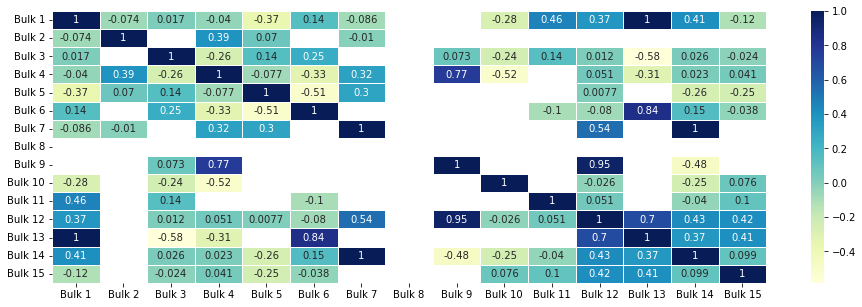


данные о продувке сплава газом

Размер датафрейма: 3239 строк и  2 столбцов.
---------------------------------------------------------------



,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
5,6,11.273392
6,7,9.836267
7,8,15.171553
8,9,8.216623
9,10,6.529891


---------------------------------------------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Газ 1   3239 non-null   float64
dtypes: float64(1)
memory usage: 25.4 KB


None

---------------------------------------------------------------



,Газ 1
count,3239.000000
mean,11.002062
std,6.220327
min,0.008399
25%,7.043089
50%,9.836267
75%,13.769915
max,77.995040


---------------------------------------------------------------

Дубликатов в датафрейме: 0
---------------------------------------------------------------



'Больше всего пропущенных значений в столбцах:'

Газ 1    0
dtype: int64

---------------------------------------------------------------



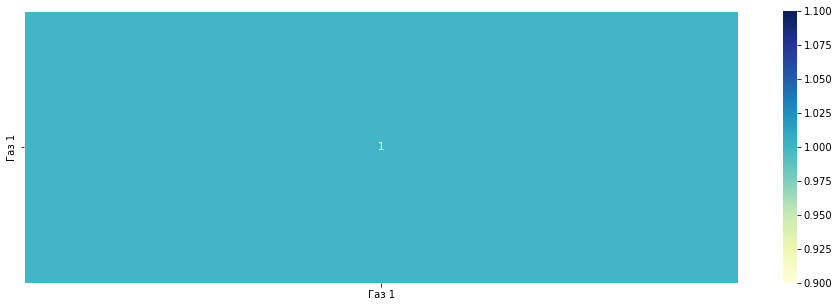


результаты измерения температуры

Размер датафрейма: 18092 строк и  3 столбцов.
---------------------------------------------------------------



,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
5,1,2019-05-03 11:30:38,1613.0
6,2,2019-05-03 11:34:04,1581.0
7,2,2019-05-03 11:38:40,1577.0
8,2,2019-05-03 11:46:09,1589.0
9,2,2019-05-03 11:49:38,1604.0


---------------------------------------------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Время замера  18092 non-null  object 
 1   Температура   14665 non-null  float64
dtypes: float64(1), object(1)
memory usage: 282.8+ KB


None

---------------------------------------------------------------



,Температура
count,14665.000000
mean,1590.722741
std,20.394381
min,1191.000000
25%,1580.000000
50%,1590.000000
75%,1599.000000
max,1705.000000


---------------------------------------------------------------

Дубликатов в датафрейме: 0
---------------------------------------------------------------



'Больше всего пропущенных значений в столбцах:'

Температура     3427
Время замера       0
dtype: int64

---------------------------------------------------------------



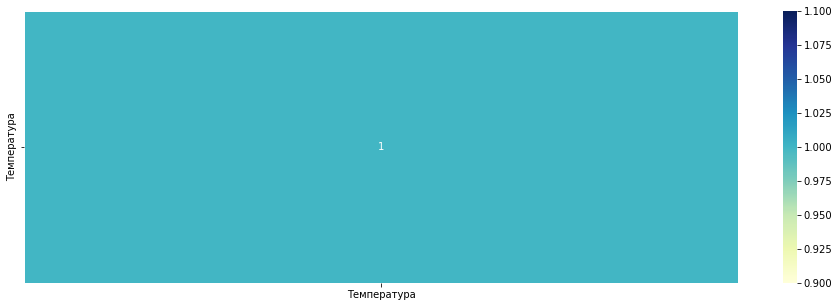


данные о проволочных материалах (объём)

Размер датафрейма: 3081 строк и  10 столбцов.
---------------------------------------------------------------



,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,99.109917,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,98.061600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,155.282394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,113.393279,9.143681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,81.244796,12.376000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


---------------------------------------------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Wire 1  3055 non-null   float64
 1   Wire 2  1079 non-null   float64
 2   Wire 3  63 non-null     float64
 3   Wire 4  14 non-null     float64
 4   Wire 5  1 non-null      float64
 5   Wire 6  73 non-null     float64
 6   Wire 7  11 non-null     float64
 7   Wire 8  19 non-null     float64
 8   Wire 9  29 non-null     float64
dtypes: float64(9)
memory usage: 216.8 KB


None

---------------------------------------------------------------



,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,100.895853,50.577323,189.482681,57.442842,15.132,48.016974,10.039007,53.625193,34.155752
std,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


---------------------------------------------------------------

Дубликатов в датафрейме: 403
---------------------------------------------------------------



'Больше всего пропущенных значений в столбцах:'

Wire 5    3080
Wire 7    3070
Wire 4    3067
Wire 8    3062
Wire 9    3052
Wire 3    3018
Wire 6    3008
Wire 2    2002
Wire 1      26
dtype: int64

---------------------------------------------------------------



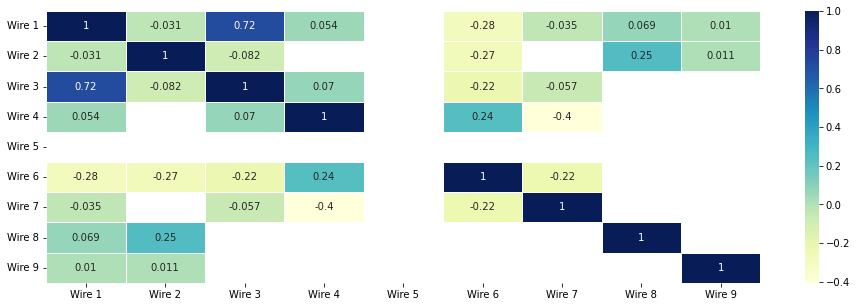

In [4]:
for name, df in datanames.items():
    print(name)
    analys(df)

#### Мощность

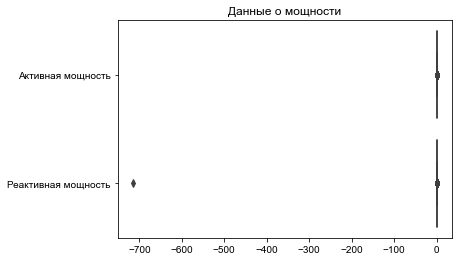

In [5]:
sns.boxplot(data=data_arc_new.drop('key', axis=1), orient='h').set_title('Данные о мощности')
sns.set(rc={'figure.figsize':(20,4)});

Мы видим, что в признаке с реактивной мощность. существует сильно отрицательная реактивная мощность равная -715.479924. Это явно выброс. Избавимся от него на этапе предобработки.

Так же взглянем на самые большие количества итераций (количество нагревов) в рамках одной партии.

In [6]:
data_arc_new.key.value_counts().head(20)

2108    16
1513    15
1689    15
2567    14
46      13
322     13
1829    12
44      12
2916    12
2917    11
638     11
1958    11
2926    11
1880    11
1470    10
2631    10
1014    10
274     10
709     10
2046    10
Name: key, dtype: int64

На этом примере мы видим, что наша задача явно актуальна: модель поможет сократить количество итераций и оптимизировать нагрев.

#### Сыпучие материалы

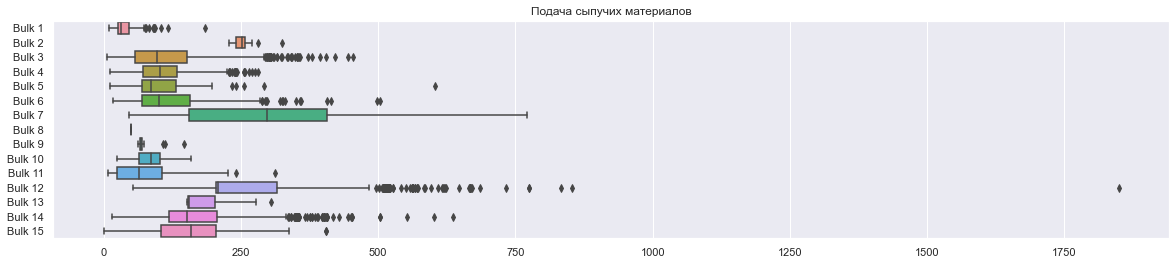

In [7]:
sns.boxplot(data=data_bulk_new.drop('key', axis=1), orient='h').set_title('Подача сыпучих материалов')
sns.set(rc={'figure.figsize':(15,4)});

В таблице с данными о подаче сыпучих материалов, в признаке `Bulk 12` так же присутствует значение, более чем в 9 раз превышающее медианное значение. Избавимся от этой итерации на следующем шаге нашего исследования.

При этом признак `Bulk 8` имеет всего одно значение. От него так же избавимся в будущем.

#### Газ

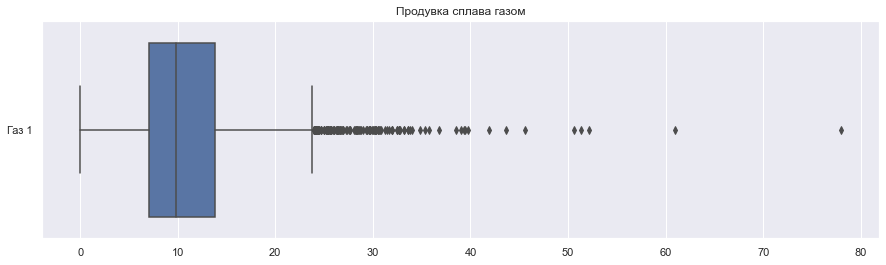

In [8]:
sns.boxplot(data=data_gas_new.drop('key', axis=1), orient='h').set_title('Продувка сплава газом')
sns.set(rc={'figure.figsize':(15,4)});

В таблице с данными о продувке сплава газом тоже есть выбросы. Ограничим их далее.

#### Температура

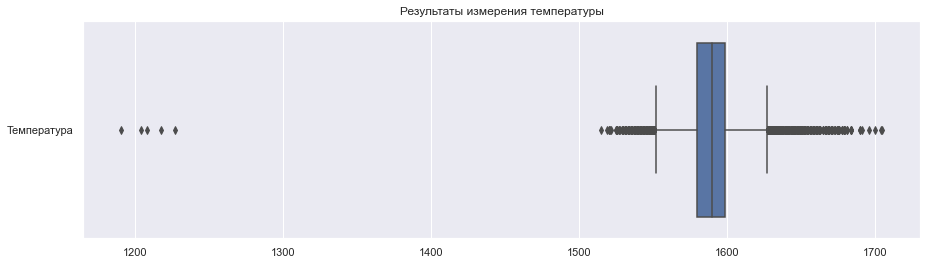

In [9]:
sns.boxplot(data=data_temp_new.drop('key', axis=1), orient='h').set_title('Результаты измерения температуры')
sns.set(rc={'figure.figsize':(15,4)});

В датасете с целевым признаком так же присутствует несколько значений с низкой температурой. Стандартным отклонением является 20 градусов, а эти значения почти на 400 градусов ниже! Нам они явно помешают в исследовании, поэтому от них стоит избавиться.

#### Проволочные материалы

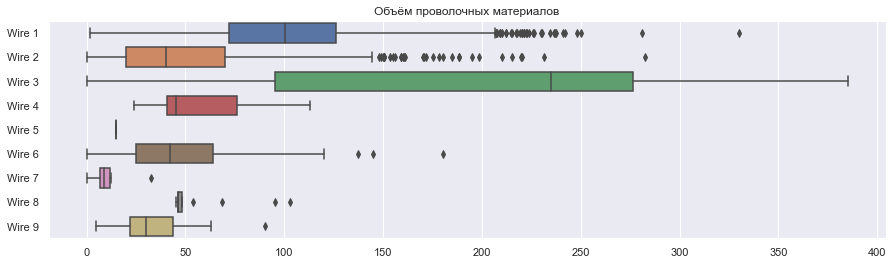

In [10]:
sns.boxplot(data=data_wire_new.drop('key', axis=1), orient='h').set_title('Объём проволочных материалов')
sns.set(rc={'figure.figsize':(15,4)});

Здесь всё в пределах разумного. Высоких не так много и они понадобятся для исследования

### Промежуточный вывод


Мы познакомились с данными и узнали:
1. В нашем распоряжении большое количество таблиц, в которых содержится данные о 3241 партиях обработки стали
2. Основные признаки, такие как *замеры температуры, данные о мощности, объём газа* имеют выбросоы.
3. Существуют партии, в которых было больше 10 (а максимально - 16) итераций по нагреву сплава.
4. В таблицах с сыпучими и проволочными материалами, между некоторыми столбцами существует высокая корреляция, однако пока сложно сказать, что это может значит.

На следующем шаге мы объединим данные по ключу, который содежится во всех таблицах и почистим данные.

# План решения задачи
1. **Провести исследовательский анализ:** Познакомиться с данными, понять как устроены таблицы, найти закономерности, связи, инсайты.
2. **Предобработка данных:** Собрать единую таблицу, в которую войдут данные, почищенные от пропущенных значений, выбросов и неважных для нас признаков. Из тренировочной выборки мы удалим *выбросы, аномальные мощности и низкую температуру*. Из тестовой выборке мы не будем ничего удалять, кроме отрицательного значения реактивной мощности и температур, ниже 1500 градусов.
3. **Обучение моделей:** Выбрать оптимальные модели для задачи регрессии. Подобрав оптимальные гиперпараметры, обучить разные модели на этих данных. Для нашего исследования предлагаю взять модель `Случайного леса, модель регрессии Lasso и CatBoostRegressor`. Думаю, что они отлично подойдут для нашей задачи, так как, `Случайный лес` удобен и подвижен в задаче регрессии и подбора гиперпараметров к ней, `Lasso` отлично борется с мультиколлинеарностью, а `CatBoost` имеет высокую точность и скорость.
4. **Общий вывод:** Проверить, удалось ли достичь поставленных задач. Оставить рекомендации и советы для улучшения и оптимизации процесса обработки стали

<a id=prepare> </a>
# 2. Подготовка данных

Для начала переименуем колонки для удобства дальнейшей работы.

In [11]:
data_arc_new = data_arc_new.rename(columns={"Активная мощность": "active_power", "Реактивная мощность": "reactive_power"})
data_temp_new = data_temp_new.rename(columns={"Температура": "temp"})
data_gas_new = data_gas_new.rename(columns={"Газ 1": "gas"});

<a id=anomalies> </a>
### 2.1 Аномальные значения

Взглянем на аномальные значения.


In [12]:
data_arc_new[data_arc_new['reactive_power'] < -500]

,key,Начало нагрева дугой,Конец нагрева дугой,active_power,reactive_power
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924


Избавимся от всей партии, в которой встречается отрицательная мощность.

In [13]:
data_arc_new = data_arc_new.loc[data_arc_new.key != 2116]

Проверим, удалось ли избавиться от выброса.

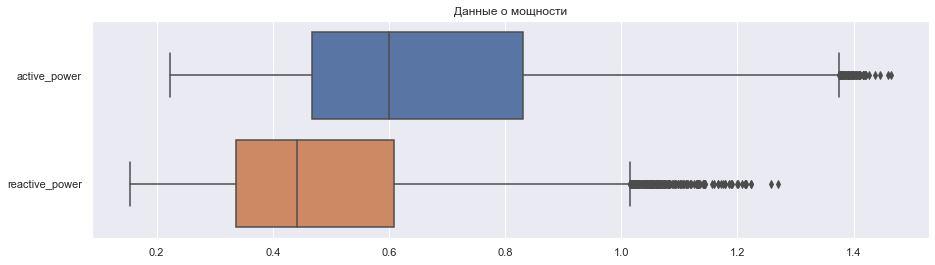

In [14]:
sns.boxplot(data=data_arc_new.drop('key', axis=1), orient='h').set_title('Данные о мощности')
sns.set(rc={'figure.figsize':(15,4)});

Выглядит отлично, переходим к температурам.

In [15]:
data_temp_new[data_temp_new['temp'] < 1500]

,key,Время замера,temp
4883,867,2019-06-06 08:03:39,1191.0
6784,1214,2019-06-18 08:01:03,1208.0
9050,1619,2019-07-03 02:34:41,1218.0
11495,2052,2019-07-25 08:49:15,1227.0
14283,2561,2019-08-12 18:49:29,1204.0


In [16]:
# создадим список с ключами, от которых мы избавимся
keys_to_delete = [867, 1214, 1619, 2052, 2561]
data_temp_new = data_temp_new[data_temp_new.key.isin(keys_to_delete) == False ]

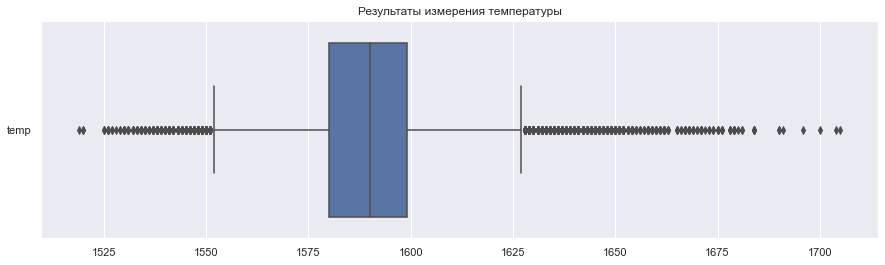

In [17]:
sns.boxplot(data=data_temp_new.drop('key', axis=1), orient='h').set_title('Результаты измерения температуры')
sns.set(rc={'figure.figsize':(15,4)});

<a id=group> </a>
### 2.2 Группировка и сборка датафрейма

От аномалий избавились, теперь приступим к группировке и сборке единого датафрейма.

#### Мощность

In [18]:
# возьмём средние значения по партиям признаков Активная мощность и Реактивная мощность
data_arc_agg = data_arc_new.groupby('key')[['active_power', 'reactive_power']].mean()
# возьмём суммы Активных и Реактивных мощностей внутри партии
data_arc_agg['active_power_sum'] = data_arc_new.groupby('key')['active_power'].sum()
data_arc_agg['reactive_power_sum'] = data_arc_new.groupby('key')['reactive_power'].sum()
# добавим сумму активной и реактивной мощности
data_arc_agg['general_power_sum'] = data_arc_agg['active_power'] + data_arc_agg['reactive_power']
data_arc_agg.head(7)

,active_power,reactive_power,active_power_sum,reactive_power_sum,general_power_sum
key,,,,,
1,0.607346,0.428564,3.036730,2.142821,1.035910
2,0.534852,0.363339,2.139408,1.453357,0.898191
3,0.812728,0.587491,4.063641,2.937457,1.400220
4,0.676622,0.514248,2.706489,2.056992,1.190870
5,0.563238,0.421998,2.252950,1.687991,0.985235
6,0.681319,0.470328,2.725274,1.881313,1.151647
7,0.656719,0.490105,2.626877,1.960419,1.146824


#### Температура

In [19]:
# в новую таблицу сохраним первые значения температур в партии, избавившись от столбца со временем замера
data_temp_grouped = data_temp_new.drop('Время замера', axis=1).groupby('key').head(1).rename({'temp':'start_temp'}, axis=1)
data_temp_grouped.head(7)

,key,start_temp
0,1,1571.0
6,2,1581.0
11,3,1596.0
17,4,1601.0
22,5,1576.0
27,6,1543.0
32,7,1586.0


In [20]:
# создадим так же Series с последними значениями температур в партии
last_temp = data_temp_new.drop('Время замера', axis=1).groupby('key').tail(1)
last_temp = last_temp.set_index('key')
last_temp.head()

,temp
key,
1,1613.0
2,1602.0
3,1599.0
4,1625.0
5,1602.0


False    2473
True      738
Name: temp, dtype: int64


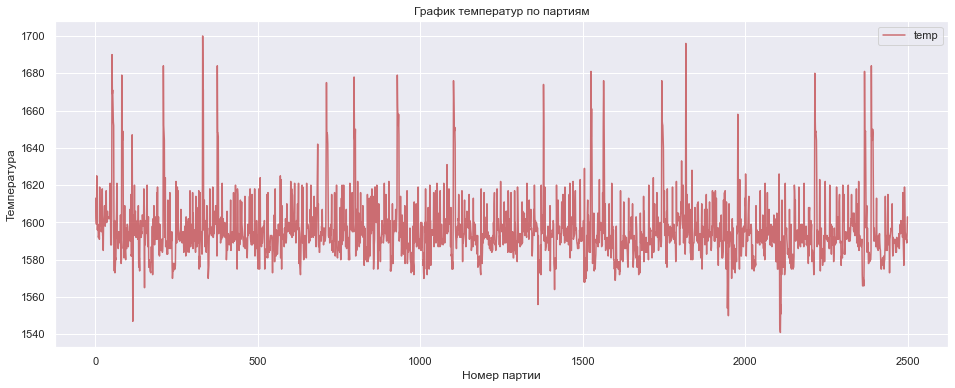

In [21]:
# проверим сколько строк имеют NaN
print(last_temp.temp.isna().value_counts())
# построим график с температурами
last_temp.plot(kind='line', y='temp', figsize=(16,6), color='r', alpha=0.8)
plt.xlabel("Номер партии")
plt.ylabel("Температура")
plt.title("График температур по партиям");

Измерения кончаются на 2500 партии. В 738 партиях значения отсутствуют. Значит нам придётся ограничить обучающую выборку, чтобы корректно обучить модель.

In [22]:
last_temp = last_temp.loc[last_temp['temp'].isna() == False]
last_temp

,temp
key,
1,1613.0
2,1602.0
3,1599.0
4,1625.0
5,1602.0
...,...
2495,1591.0
2496,1591.0
2497,1589.0


In [23]:
# проверим, какие температуры встречаются чаще всего
last_temp.temp.value_counts().head(10)

1593.0    134
1592.0    129
1591.0    122
1595.0    121
1594.0    121
1589.0    117
1590.0    112
1596.0     94
1597.0     93
1587.0     80
Name: temp, dtype: int64

Мы видим, что наиболее часто встречающиеся значения находятся в промежутке между 1589 и 1595 градусами. 

#### Сыпучие смеси

In [24]:
# избавимся от столбцов, где всего одно значение
data_bulk_new = data_bulk_new.drop(['Bulk 8'], axis=1)
data_wire_new = data_wire_new.drop(['Wire 5'], axis=1)
#'Bulk 9', 'Bulk 13', 'Bulk 2', 'Wire 7', 'Wire 4', 'Wire 8', 'Wire 9', 'Wire 3'

Соберём датафрейм из получившихся таблиц и выведем его на экран

In [25]:
df = data_temp_grouped.merge(data_arc_agg, left_on='key', right_on='key', how='inner')\
                      .merge(data_gas_new,left_on='key', right_on='key', how='inner')\
                      .merge(data_bulk_new, left_on='key', right_on='key', how='inner')\
                      .merge(data_wire_new, left_on='key', right_on='key', how='inner')\
                      .merge(last_temp, left_on='key', right_on='key', how='inner')
                       # целевой признак тоже добавим в таблицу для того, чтобы оставить в нём только те партии,
                       # которые есть во всех остальных признаках
# приведём все столбцы к нижнему регистру
df.columns= df.columns.str.lower()
# заполним пропуски нулями
df = df.fillna(0)
# ограничим 2499 партией
df = df.loc[df.key < 2500]
# номер партии возьмём за индекс
df = df.set_index('key')
df

,start_temp,active_power,reactive_power,active_power_sum,reactive_power_sum,general_power_sum,gas,bulk 1,bulk 2,bulk 3,...,bulk 15,wire 1,wire 2,wire 3,wire 4,wire 6,wire 7,wire 8,wire 9,temp
key,,,,,,,,,,,,,,,,,,,,,
1,1571.0,0.607346,0.428564,3.036730,2.142821,1.035910,29.749986,0.0,0.0,0.0,...,154.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,1613.0
2,1581.0,0.534852,0.363339,2.139408,1.453357,0.898191,12.555561,0.0,0.0,0.0,...,154.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,1602.0
3,1596.0,0.812728,0.587491,4.063641,2.937457,1.400220,28.554793,0.0,0.0,0.0,...,153.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,1599.0
4,1601.0,0.676622,0.514248,2.706489,2.056992,1.190870,18.841219,0.0,0.0,0.0,...,154.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,1625.0
5,1576.0,0.563238,0.421998,2.252950,1.687991,0.985235,5.413692,0.0,0.0,0.0,...,152.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,1602.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,1570.0,0.792033,0.552734,3.168133,2.210936,1.344767,7.125735,0.0,0.0,21.0,...,223.0,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,1591.0
2496,1554.0,0.695820,0.478672,4.174918,2.872031,1.174491,9.412616,0.0,0.0,0.0,...,226.0,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,1591.0
2497,1571.0,1.201746,0.817364,3.605239,2.452092,2.019110,6.271699,0.0,0.0,0.0,...,226.0,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,1589.0


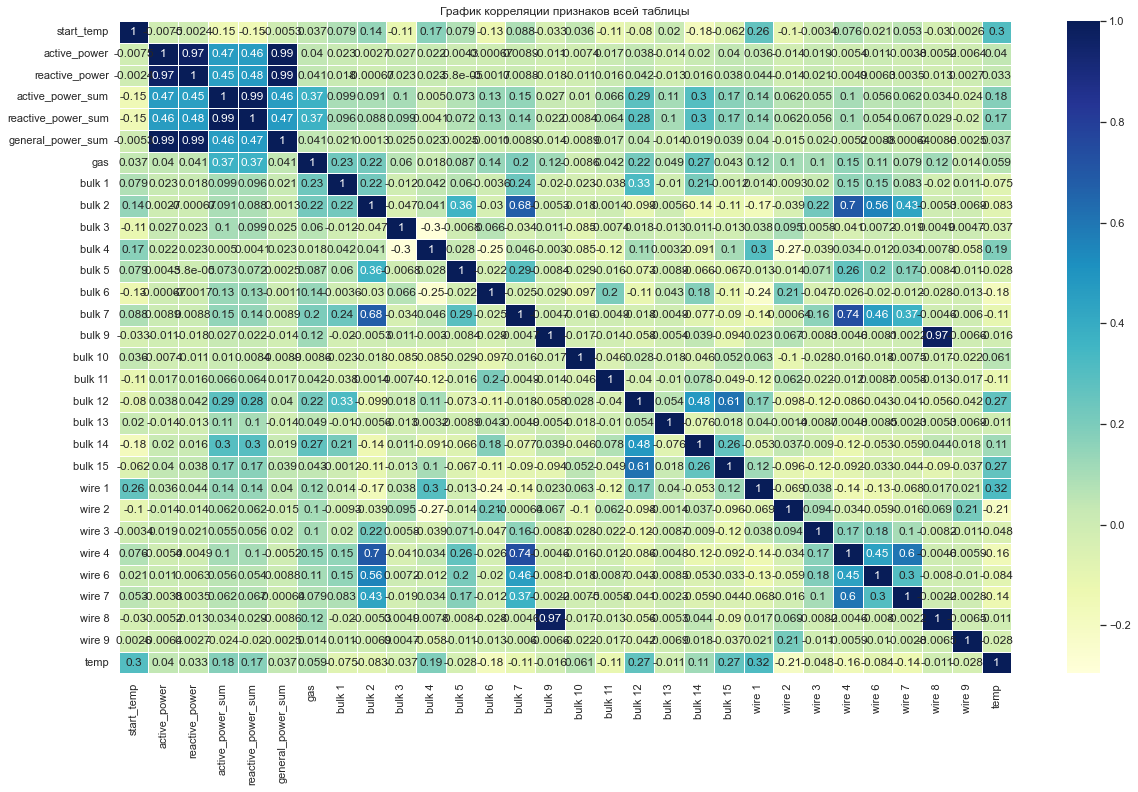

In [26]:
# график корреляции признаков между собой
plt.figure(figsize = (20,12))
sns.heatmap(df.corr(), cmap="YlGnBu", annot=True, linewidths=1).set_title('График корреляции признаков всей таблицы')
plt.show()

На графике корреляции мы видим, что некоторые признаки имеют высокую корреляцию между собой. Однако ни у одного признака нет хотя бы средней корреляции с целевым признаком.

Всё же, нам необходимо будет выбирать модели с расчётом на то, что они подойдут для борьбы с мультиколлинеарностью.

### Промежуточный вывод

На шаге предобработке мы:
1. Привели названия столбцов к удобному формату. 
2. Избавились от аномалий, обнаруженных в предыдущем шаге. 
3. Активную и реактивную мощность аггрегировали. Числа в этих признаках являются соответственно средними значениями и суммами мощностей по партии.
4. В признаке с температурой мы оставили первый замер в партии.
5. Создали целевой признак, который содержит значение последнего замера температуры в партии и выяснили, что на последних 738 итерациях замеры отсутствуют.
6. Собрали датафрейм со всей информацией, необходимой для обучения модели. Конечный датафрейм содержит в себе 2324 строки и 30 столбцов (включая целевой признак).

<a id=ml> </a>
# 3 Обучение и подбор моделей

Для начала обозначим заранее известный нам `random_state` и разделим наш датасет на тренировочную и тестовую выборки.

In [27]:
random_state = 240423

In [28]:
features = df.drop(['temp'], axis=1)
target = df.temp
features_train, features_test, target_train, target_test = \
                                        train_test_split(features, target, test_size=.25, random_state=random_state)

Из тренировочной выборки уберём выбросы в `Bulk 12`, которые мы обнаружили на первом этапе.

In [29]:
features_train.loc[features_train['bulk 12'] > 800]

,start_temp,active_power,reactive_power,active_power_sum,reactive_power_sum,general_power_sum,gas,bulk 1,bulk 2,bulk 3,...,bulk 14,bulk 15,wire 1,wire 2,wire 3,wire 4,wire 6,wire 7,wire 8,wire 9
key,,,,,,,,,,,,,,,,,,,,,
1816,1590.0,0.809036,0.630752,4.854218,3.784514,1.439789,23.48817,62.0,0.0,0.0,...,249.0,0.0,236.667587,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1999,1650.0,0.732012,0.556113,3.660062,2.780566,1.288126,7.81519,54.0,0.0,0.0,...,366.0,290.0,100.070877,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
# удалим ключи с выбросами 'bulk 12' в тестовой выборке
features_train = features_train.loc[features_train.index.isin([1816, 1999]) == False ]
target_train = target_train.loc[target_train.index.isin([1816, 1999]) == False ]

<a id=rf> </a>
## 3.1 Случайный лес

In [31]:
%%time

params={'n_estimators': [100, 500, 1000],
        'max_features': ['auto','sqrt', 'log2'],
        'max_depth' : [2, 5, 8, 10, 12, 14]}
rf = RandomForestRegressor(random_state=random_state)
grid_rf = GridSearchCV(rf, cv=5, verbose=1, n_jobs=-1, param_grid=params, scoring='neg_mean_absolute_error')

grid_rf.fit(features_train, target_train.values.ravel());

Fitting 5 folds for each of 54 candidates, totalling 270 fits
CPU times: total: 2.09 s
Wall time: 5min 50s


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=240423),
             n_jobs=-1,
             param_grid={'max_depth': [2, 5, 8, 10, 12, 14],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [100, 500, 1000]},
             scoring='neg_mean_absolute_error', verbose=1)

In [32]:
print(f"Лучшая модель: {grid_rf.best_params_}", '\n', f"Лучший MAE score = {abs(grid_rf.best_score_)}")

Лучшая модель: {'max_depth': 8, 'max_features': 'auto', 'n_estimators': 100} 
 Лучший MAE score = 7.082828259510511


Случайный лес на тренировочной выборке показал результат, чуть ниже ожидаемого - 7.082

<a id=lasso> </a>
## 3.2 Lasso Regressor

In [33]:
%%time
params={'max_iter': [50, 100, 500, 1000],
        'alpha': [0.3, 1, 2]}

lasso = Lasso(random_state=random_state)
grid_lasso = GridSearchCV(lasso, cv=5, param_grid=params, n_jobs=-1, scoring='neg_mean_absolute_error')

grid_lasso.fit(features_train, target_train.values.ravel())

CPU times: total: 125 ms
Wall time: 755 ms


GridSearchCV(cv=5, estimator=Lasso(random_state=240423), n_jobs=-1,
             param_grid={'alpha': [0.3, 1, 2],
                         'max_iter': [50, 100, 500, 1000]},
             scoring='neg_mean_absolute_error')

In [34]:
print(f"Лучшая модель: {grid_lasso.best_params_}", '\n', f"Лучший MAE score = {abs(grid_lasso.best_score_)}")

Лучшая модель: {'alpha': 0.3, 'max_iter': 50} 
 Лучший MAE score = 7.114551820772803


Lasso показал почти такой же результат, что и Случайный лес, но чуть хуже - 7.114

<a id=cb> </a>
## 3.3 CatBoostRegressor

In [35]:
train_dataset = cb.Pool(features_train, target_train)

In [36]:
%%time

params = {'depth': [1, 2],
        'learning_rate': [0.01, 0.02, 0.03, 0.1, 0.3],
        'l2_leaf_reg': [1, 20, 50, 100, 150],
          'iterations': [2500]
       }
model_cb = cb.CatBoostRegressor(loss_function='MAE', verbose=500,
                                early_stopping_rounds=100, random_state=random_state)
model_cb.grid_search(params, train_dataset, 
                     search_by_train_test_split=False, cv=5, train_size=0.75, plot=True)
model_cb.fit(features_train, np.ravel(target_train));

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]
0:	learn: 1577.2567810	test: 1577.7347558	best: 1577.7347558 (0)	total: 147ms	remaining: 6m 8s
500:	learn: 12.3446083	test: 13.0705709	best: 13.0705709 (500)	total: 766ms	remaining: 3.06s
1000:	learn: 7.0114234	test: 7.8508521	best: 7.8504711 (997)	total: 1.44s	remaining: 2.15s
1500:	learn: 6.7544402	test: 7.7100770	best: 7.7099783 (1499)	total: 2.15s	remaining: 1.43s
2000:	learn: 6.6238258	test: 7.6423135	best: 7.6423135 (2000)	total: 2.64s	remaining: 658ms
2499:	learn: 6.5327437	test: 7.5974591	best: 7.5974517 (2496)	total: 3.03s	remaining: 0us

bestTest = 7.597451672
bestIteration = 2496

Training on fold [1/5]
0:	learn: 1577.4555988	test: 1576.9750568	best: 1576.9750568 (0)	total: 824us	remaining: 2.06s
500:	learn: 12.5706164	test: 12.1175244	best: 12.1175244 (500)	total: 329ms	remaining: 1.31s
1000:	learn: 7.2451238	test: 6.8243581	best: 6.8243581 (1000)	total: 692ms	remaining: 1.04s
1500:	learn: 6.9980033	test: 6.6499263	best: 6.6497305 (1497)	total: 1.03s	

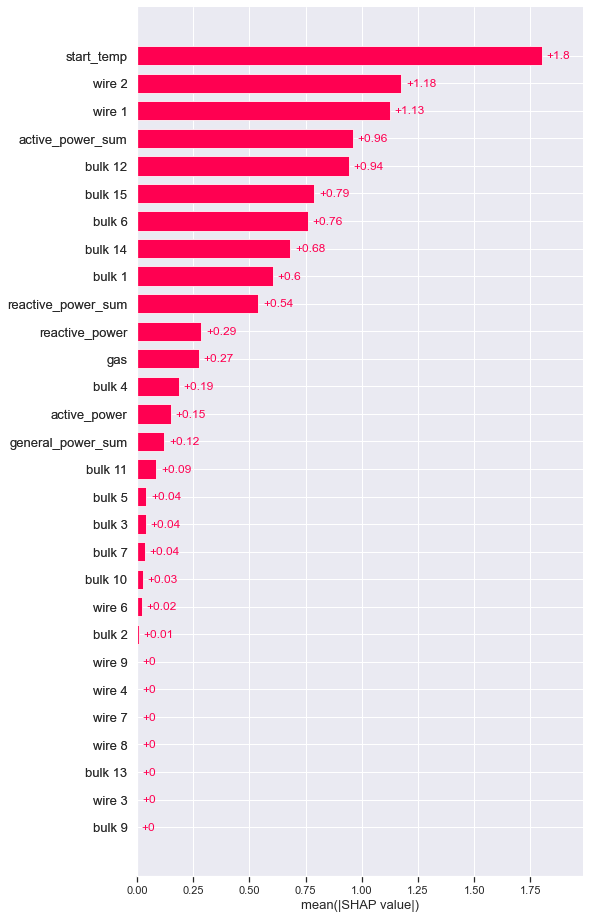

In [37]:
explainer = shap.Explainer(model_cb)
shap_values = explainer(features_test)
shap.plots.bar(shap_values, max_display=features_test.shape[0])

In [38]:
model_cb.best_score_

{'learn': {'MAE': 6.194588010404289}}

Лучший результат CatBoostRegressor равен 6.194. Выберем эту модель для проверки на тестовой выборке.

## Проверка на тестовой выборке

In [39]:
preds_cb = model_cb.predict(features_test)
mae_cb = (mean_absolute_error(target_test, preds_cb))
print(f'MAE CatBoost на тестовой выборке: {mae_cb}')

MAE CatBoost на тестовой выборке: 6.492099626968972


<a id=conclusion> </a>
# Общий вывод
Мы провели большое исследование, в ходе которого исследовали процесс обработки стали.

Мы провели исследовательский анализ данных, а так же провели предобработку, в ходе которой, избавились от некоторых признаков и выбросов, которые могли мешать дальнейшему обучению модели. Так же мы создали новые признаки, важные для обучения: мы аггрегировали мощности, взяв медианные и суммы значений мощностей внутри одной партии.

Нам удалось достичь **основной цели**: мы построили модель, *Средняя квадратичная ошибка* которой ниже заданного значения в 6.8. Наша модель градиентного бустинга показывает результат `6.49`.

Стоит отметить, что в ходе работы мы вывели наиболее часто встречающиеся конечные температуры, что может быть полезным для дальнейшей оптимизации процесса: *1593, 1592, 1591, 1595, 1594* градусов. Мы видим, что они находятся в одном небольшом диапазоне температур, что указывает на то, что могут существовать оптимальные значения, которые применимы ко многим партиям, однако это является отдельной темой для исследования.

Так же мы построили график с важностью признаков, который показал, что наиболее важными признаками, влияющими на целевой признак являются `Стартовая температура`, первые два признака `Проволочных материалов`, а так же 12-й признак `Сыпучих смесей` и `Активная мощность`. При дальнейшей оптимизации, стоит учесть именно эти признаки.